In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/training/10_08_24_Roads_RandomCrop500_small",
    # "/storage/vbutoi/scratch/ESE/training/10_08_24_Roads_RandomCrop500_big",
    # "/storage/vbutoi/scratch/ESE/training/August_2024/08_07_24_OCTA_FULLRES_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/calibration/August_2024/08_11_24_OCTA_FULLRES_LTS_LongRuns",
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)

df = pd.concat(df_list_1)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [3]:
df['lr'].unique()

array([0.0001])

In [4]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
area_estimation_error
dice_score
ece_loss
data
iters_per_epoch
label
label_threshold
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
loss_func
batch_reduction
from_logits
model
filters
image_channels
img_channels
num_classes
optim
lr
weight_decay
checkpoint
epochs
eval_freq
pretrained_dir
pretrained_select_metric
path


In [5]:
# Subselect the pretrained dir
# df = df[df['base_pretrained_dir'] == '/storage/vbutoi/scratch/ESE/training/09_25_24_ISLES_3D_Dice_HeavyAug/20240925_234556-HGRQ-56cd3bf7df7a1b7d2a453b296d64407d']

In [6]:
# Limit the rows to those with lr = 1e-5
# df = df[df['lr'] == 1e-5]

In [7]:
def exp_name(path):
    exp_root = str(path).split("/")[-2]
    return exp_root

def aug_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_26_24_ISLES_3D_LTS_AllAug_v2_ElasticOnly":
        exp_n = "spatial"
    elif exp_root == "09_26_24_ISLES_3D_LTS_AllAugBackbone_v2":
        exp_n = "intensity + spatial"
    else:
        raise ValueError("Unknown experiment root")
    return exp_n

def norm_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_BATCHNORM":
        exp_n = "batch"
    elif exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_LAYERNORM":
        exp_n = "layer"
    else:
        exp_n = "None"
    return exp_n

df.augment(exp_name)
# df.augment(aug_type)
df.augment(norm_type)

In [8]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

In [9]:
# We want to make sure that train goes before val in the phase
df['phase'] = df['phase'].astype('category')
df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)

<ipython-input-9-ee3f85ac4261>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)


In [10]:
# Look only at seed 40
df = df[df['seed'] == 40]

In [11]:
# Show every 10 epochs to smooth the plot
df = df[df['epoch'] % 10 == 0]

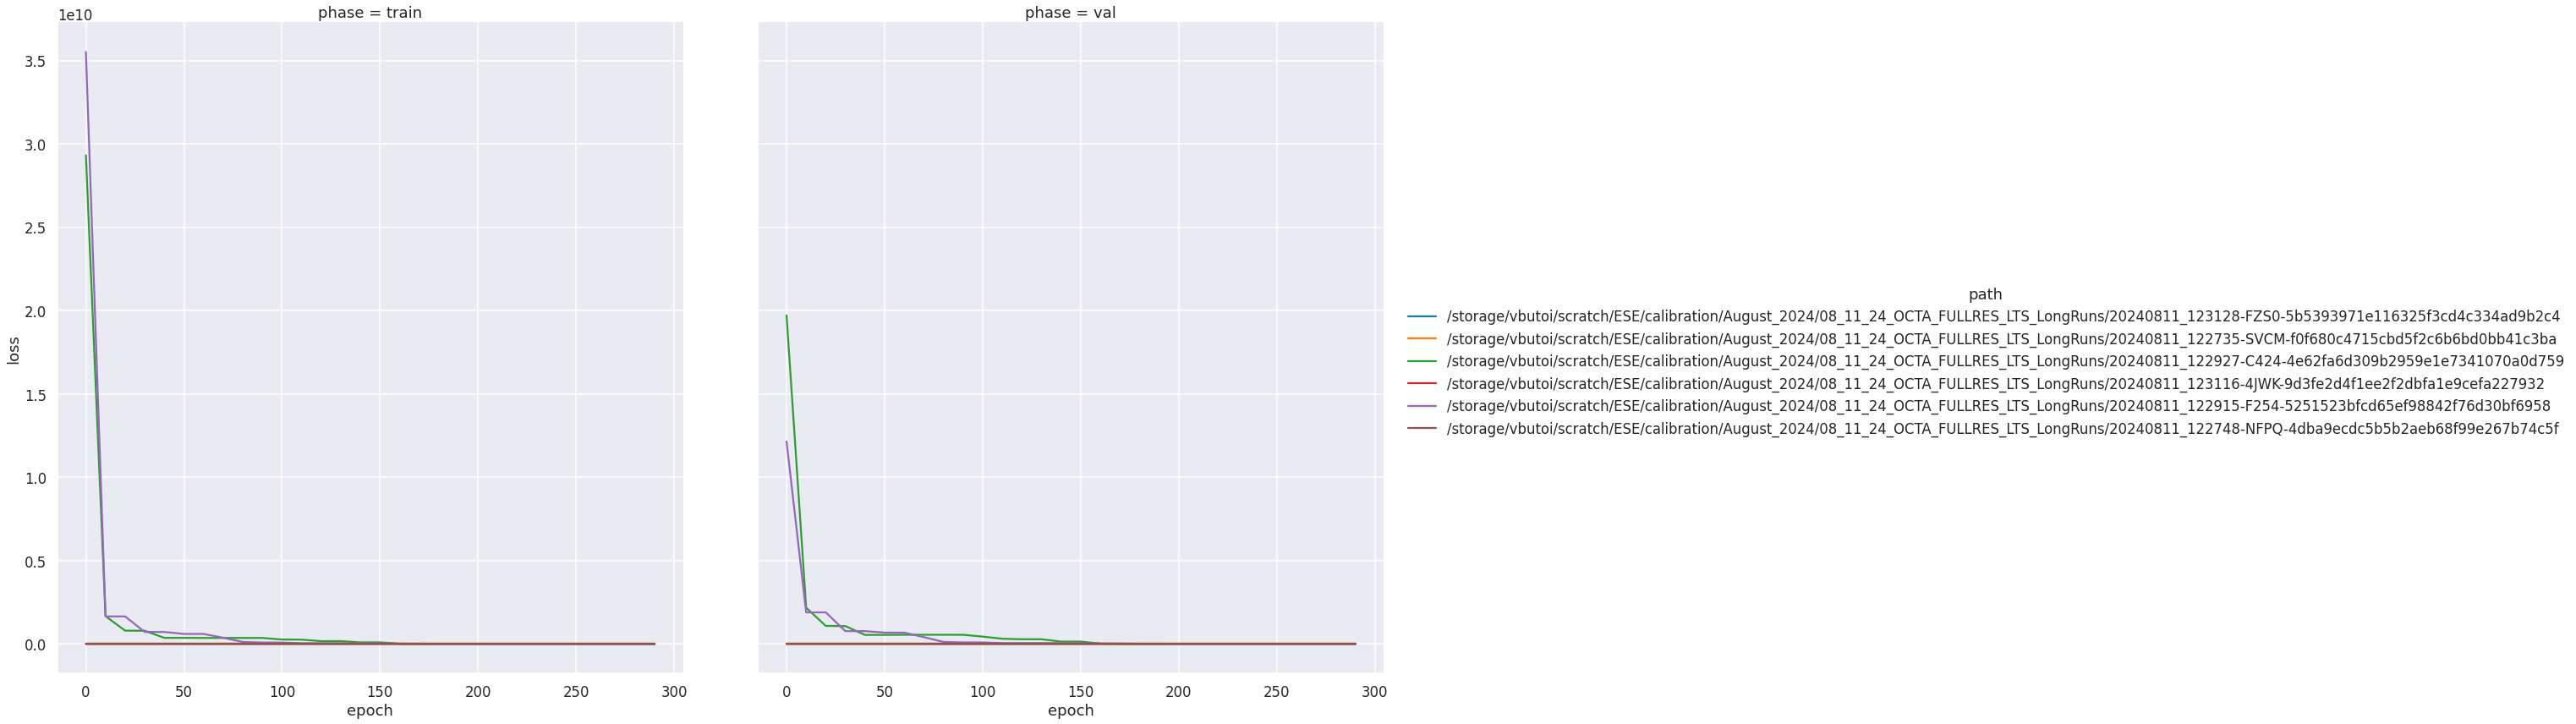

In [12]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='path',
    col='phase',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
# Set the y axis to be between 0 and 1
# g.set(ylim=(0, 1000))

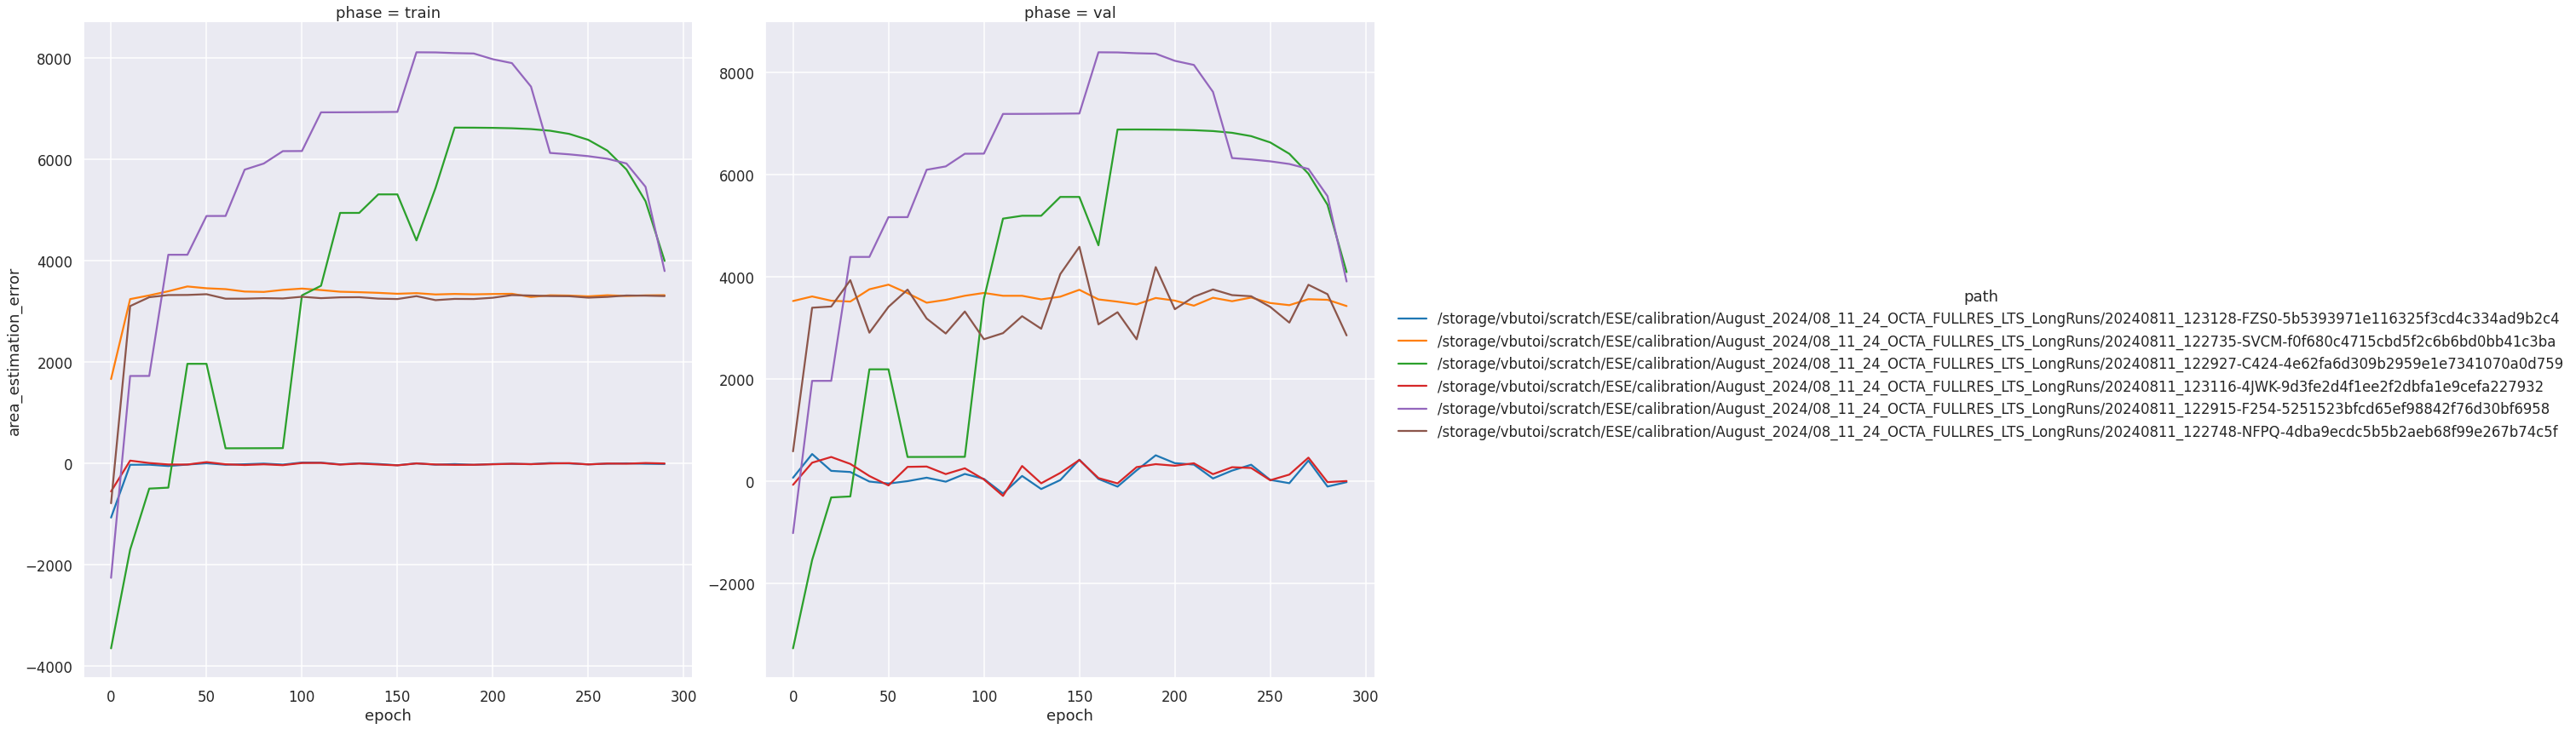

In [15]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='area_estimation_error',
    hue='path',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
## Set the y lim
# g.set(ylim=(0, 2000))